In [1]:
from behavioral_models import *
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn import preprocessing
from scipy.stats import pearsonr

Load behavioral data.

In [2]:
beh_path = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/" \
           "data/main_fmri_study/behavioral/behavioral_data_clean_all.npy"
beh_meta_path = beh_path.replace('npy', 'json')

# Load behavioral data
beh = np.load(beh_path)
with open(beh_meta_path, 'r') as f:
    meta = json.loads(f.read())

print("Shape of beh array:", beh.shape)
print("Conditions", [(i, cond)for i, cond in enumerate(meta['dim2'])])
print("Columns:", [(i, col) for i, col in enumerate(meta['dim4'])])

n_subjects = beh.shape[0]
n_conditions = 2

Shape of beh array: (32, 2, 110, 21)
Conditions [(0, 'rew'), (1, 'pun')]
Columns: [(0, 'block'), (1, 'rwd'), (2, 'magn_left'), (3, 'magn_right'), (4, 'response'), (5, 'rt'), (6, 'won_bool'), (7, 'won_magn'), (8, 'acc_after_trial'), (9, 'onset_iti'), (10, 'onset_iti_plan'), (11, 'onset_iti_glob'), (12, 'onset_dec'), (13, 'onset_dec_plan'), (14, 'onset_dec_glob'), (15, 'onset_isi'), (16, 'onset_isi_plan'), (17, 'onset_isi_glob'), (18, 'onset_out'), (19, 'onset_out_plan'), (20, 'onset_out_glob')]


### Correlation between expected utility (value) and expected probability of winning.
This section calculates two choice regressors for different values of parameters and explore correlation among them. Regressors are time locked to the choice phase. 

In [7]:
def get_response_mask(beh, meta, subject, condition):
    """Return masking array indicating subject response.
    
    Args:
        beh (np.array): aggregated behavioral responses
        meta (dict): description of beh array coding
        subject (int): subject index
        condition (int): task condition index
    
    Returns:
        (np.array): mask array for subject response 
            1: indicate that option was selected
            0: option was not selected
            size: n_trials x 2
    """
    resp = (beh[subject, condition, :, meta['dim4'].index('response')] + 1) / 2
    mask_resp = np.hstack((1-resp[:, np.newaxis], resp[:, np.newaxis]))
    mask_resp[mask_resp == .5] = 0
    return mask_resp

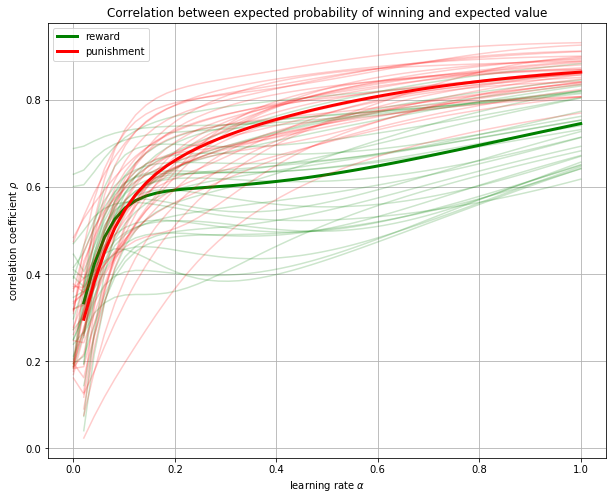

In [11]:
# define range of parameters
n_alpha = 50 
alpha_range = np.linspace(0, 1, n_alpha)

val_util_corr = np.zeros((n_subjects, n_alpha))

fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='w', figsize=(10, 8))

for ci, condition in enumerate(['reward', "punishment"]):
    for subject in range(n_subjects):
        
        mask_resp = get_response_mask(beh, meta, subject, ci)
        
        for i, alpha in enumerate(alpha_range):
            # Get model predictions & calculate exp_val and exp_util
            val, util, _ = model1(beh, meta, subject, ci, alpha)
            if ci == 0:    exp_val = np.sum(val * mask_resp, axis=1)
            elif ci == 1:  exp_val = np.sum(1-val * mask_resp, axis=1)
            exp_util = np.sum(util * val * mask_resp, axis=1)

            val_util_corr[subject, i] = pearsonr(exp_val, exp_util)[0]

    if condition == "reward":       color='g'
    elif condition == "punishment": color='r'
    for subject in range(n_subjects):
        ax.plot(alpha_range, val_util_corr[subject], alpha=.2, color=color)
    ax.plot(alpha_range, np.mean(val_util_corr, axis=0),
            color=color, linewidth=3, label=condition)
    ax.set_xlabel(r"learning rate $\alpha$")
    ax.set_ylabel(r"correlation coefficient $\rho$")

plt.title("Correlation between expected probability of winning and expected value")  
plt.legend()
plt.grid()

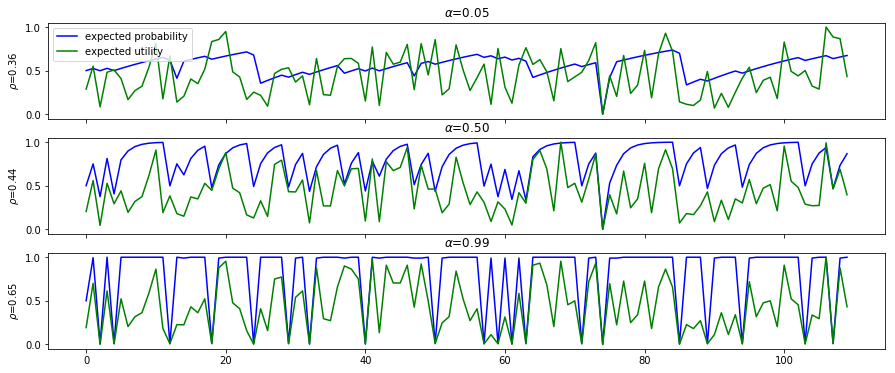

In [78]:
subject = 22
condition = 0

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, 
                       facecolor='w', figsize=(15, 6))

for i, alpha in enumerate([.05, .5, .99]):

    val, util, _ = model1(beh, meta, subject, condition, alpha)
    mask_resp = get_response_mask(beh, meta, subject, condition)
    if condition == 0:    exp_val = np.sum(val * mask_resp, axis=1)
    elif condition == 1:  exp_val = np.sum(1-val * mask_resp, axis=1)
    exp_util = np.sum(util * val * mask_resp, axis=1)
    exp_util = exp_util / np.max(exp_util)

    ax[i].plot(exp_val, 'b', label="expected probability")
    ax[i].plot(exp_util, 'g', label="expected utility")
    rho = pearsonr(exp_val, exp_util)[0]
    ax[i].set_ylabel(r"$\rho$"+f"={rho:.2f}")
    ax[i].set_title(r"$\alpha$"+f"={alpha:.2f}")
    
ax[0].legend(loc='upper left')

### Explore how model works.
- is expected utility corrlated with expected probability of winning?

In [ ]:
# Select subject & condition
sub = 1
con = 0
# Parameter values
alpha = .1
gamma = 1
delta = 1 

nx, ny = (100, 100)
x = np.linspace(0, .1, nx) #alpha
y = np.linspace(0, 1, ny) #gamma
xv, yv = np.meshgrid(x, y)
rho = np.zeros((nx, ny))

for i in range(nx):
    for j in range(ny):
        
        val, util, p = model3(beh, meta, sub, con, 
                              alpha=xv[i,j], theta=.5,
                              gamma=yv[i,j], delta=1)

        # Get response mask and reward mask
        resp = (beh[sub, con, :, 4]+1)/2
        mask_resp = np.hstack((1-resp[:, np.newaxis], resp[:, np.newaxis]))
        mask_resp[mask_resp == .5] = 0

        # Calculate prediction errors
        pe_prob_chosen = beh[sub, con, :, 6] - np.sum(val*mask_resp, axis=1) 
        if con == 0:
            pe_value_chosen = np.sum(util*mask_resp, axis=1)*beh[sub, con, :, 6] - np.sum(val*util*mask_resp, axis=1) 
        elif con == 1:
            pe_value_chosen = np.sum(util*mask_resp, axis=1)*(1-beh[sub, con, :, 6]) - np.sum(val*util*mask_resp, axis=1) 
        rho[i, j] = pearsonr(pe_prob_chosen, pe_value_chosen)[0]


# Plotting 
# fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='w', figsize=(20, 15))

# val_n = preprocessing.normalize([val[:, 0]])[0]
# util_n = preprocessing.normalize([util[:, 0]])[0]

# ax.stem(
#     np.arange(110)+1+.4, 
#     preprocessing.normalize([pe_prob_chosen])[0],
#     label='probability PE')
# ax.stem(
#     np.arange(110)+1, 
#     preprocessing.normalize([pe_value_chosen])[0],
#     'g', label='utility PE')
# plt.title(f"r = {rho:0.3}")
# plt.legend()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15), facecolor='w')
im = ax.imshow(rho, cmap='hot_r')
plt.colorbar(im)